# Тема курсовой работы: «Предварительный анализ данных и построение признаков в задачах идентификации личности по голосу»

**Задачи:**
* Произвести обработку аудиофайлов
* Реализовать анализ имеющегося набора данных 
* Выявить наилучшую модель классификации с наиболее высокими показателями качества обучения модели

**Цель:** проведение анализа существующих методов распознавания голоса и моделировании процесса идентификации с использованием мел-частотных кепстральных коэффициентов.

**План работы:**
*   Получение признаков из аудио в общем случае
*   Загрузка и описание датасета
*   Предварительный анализ и очистка данных
*   Построение моделей классификации
*   Сравнение моделей
*   Улучшение модели
*   Заключение


In [1]:
# Импортируем необходимые для работы библиотеки

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import glob
import librosa
import librosa.display
import IPython.display as ipd

# модели машинного обучения
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

# метрики точности моделей
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

## Получение признаков из аудио
Разберем работу алгоритма по получению мел-кепстральных коэффициентов на примере следующего аудиофайла:

In [2]:
speaker_file = '00001.wav'
ipd.Audio(speaker_file)

При помощи функции load из библиотеки librosa можно загрузить и декодировать звук как временной ряд. На выход мы получаем два параметра - одномерный массив numpy и sample_rate - частоту дискретизации.

In [4]:
audio_data, sr = librosa.load(speaker_file)

print("Информация о файле", speaker_file)
print("Длительность аудиофайла:", librosa.get_duration(y=audio_data, sr=sr), "секунд")
print("Частота дискретизации (sampling rate):", sr, "Гц")
print("Количество сэмплов:", len(audio_data))

Информация о файле 00001.wav
Длительность аудиофайла: 10.200090702947845 секунд
Частота дискретизации (sampling rate): 22050 Гц
Количество сэмплов: 224912


Спектрограмма — это визуальный способ представления уровня или “громкости” сигнала во времени на различных частотах, присутствующих в форме волны. Обычно изображается в виде тепловой карты.

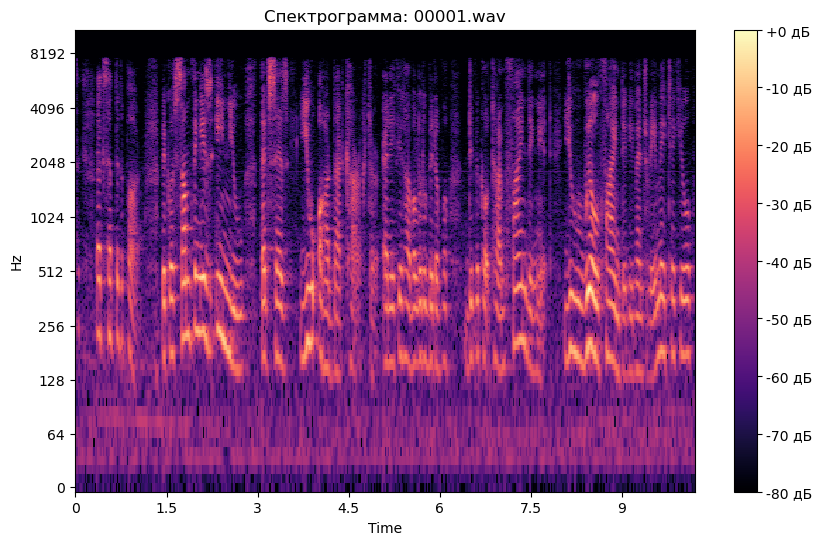

In [5]:
def display_spectrogram(audio_path):
    '''Отображение спектрограммы аудиофайла'''
    y, sr = librosa.load(audio_path)
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max), sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f дБ')
    plt.title('Спектрограмма: ' + audio_path)
    plt.show()
display_spectrogram('00001.wav')

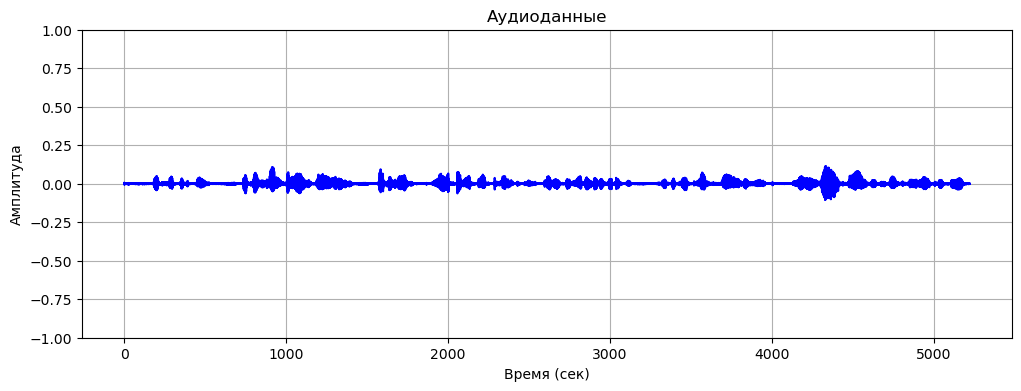

In [6]:
time_ = librosa.times_like(audio_data, sr=sr)

plt.figure(figsize=(12, 4))
plt.plot(time_, audio_data, color='b')
plt.title('Аудиоданные')
plt.xlabel('Время (сек)')
plt.ylabel('Амплитуда')
plt.ylim(-1, 1)
plt.grid(True)
plt.show()

In [7]:
def normalize(audio_data):
    '''Нормализация для приведения сигналов к одинаковой амплитуде'''
    normalized_audio_data = audio_data / np.max(np.abs(audio_data))

    return normalized_audio_data

In [9]:
audio_data = normalize(audio_data)

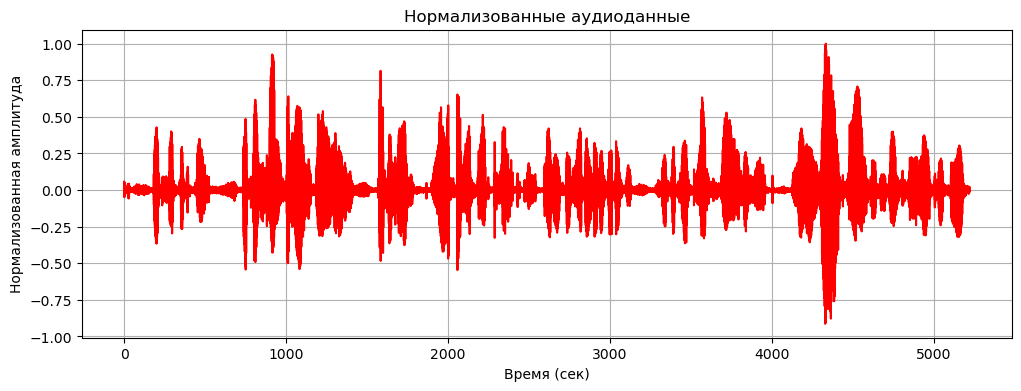

In [11]:
plt.figure(figsize=(12, 4))
plt.plot(time_, audio_data, color='r')
plt.title('Нормализованные аудиоданные')
plt.xlabel('Время (сек)')
plt.ylabel('Нормализованная амплитуда')
plt.grid(True)
plt.show()

Разбиение аудиоданных на фреймы позволяет адаптировать методы анализа сигналов, такие как вычисление спектрограммы или извлечение признаков, к анализу аудиосигнала в пределах каждого фрейма, что повышает эффективность обработки данных и позволяет учитывать временные изменения в сигнале. Кроме того, это необходимо для дальнейшего преобразования Фурье.

In [12]:
def frame(audio, FFT_size=2048, hop_size=10, sample_rate=44100):
    '''Функция разбивает аудиосигнал на фреймы с заданным размером и шагом.'''
    audio = np.pad(
        audio, int(FFT_size / 2), mode="reflect"
    )  # паддинг для прохождения окном
    frame_len = np.round(sample_rate * hop_size / 1000).astype(int)
    frame_num = int((len(audio) - FFT_size) / frame_len) + 1
    frames = np.zeros((frame_num, FFT_size))

    for n in range(frame_num):
        frames[n] = audio[n * frame_len : n * frame_len + FFT_size]

    return frames

In [13]:
def plot_audio(audio):
    plt.figure(figsize=(15, 4))
    plt.plot(np.linspace(0, len(audio) / sr, num=len(audio)), audio)

    plt.grid()

In [14]:
hop_size = 25  # длина фрейма в миллисекундах
FFT_size = 2048

audio_data = frame(audio_data, FFT_size=FFT_size, hop_size=hop_size, sample_rate=sr)

Визуально оценим изменения амплитуды звука в течение времени

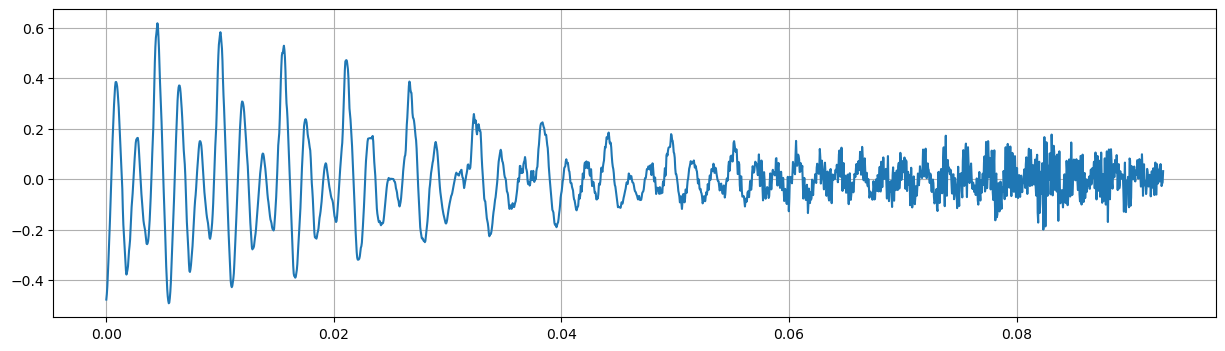

In [15]:
plot_audio(audio_data[65])

Дальнейшая предобработка включает в себя применение оконных функций, которые широко используются для ограничения сигнала во времени и уменьшения так называемого "растекания спектра" - появления побочных составляющих в спектральном составе последовательности (сигнала) при вычислении дискретного преобразования Фурье.

In [16]:
def hanning_window(length):
    window = np.zeros(length)
    for n in range(length):
        window[n] = 0.5 * (1 - np.cos(2 * np.pi * n / (length - 1)))
    return window

def kaiser_window(length, beta):
    window = np.zeros(length)
    for n in range(length):
        window[n] = np.i0(beta * np.sqrt(1 - ((n - (length - 1) / 2) / ((length - 1) / 2)) ** 2)) / np.i0(beta)
    return window

def hamming_window(length):
    window = np.zeros(length)
    for n in range(length):
        window[n] = 0.54 - 0.46 * np.cos(2 * np.pi * n / (length - 1))
    return window

def rectangular_window(length):
    return np.ones(length)

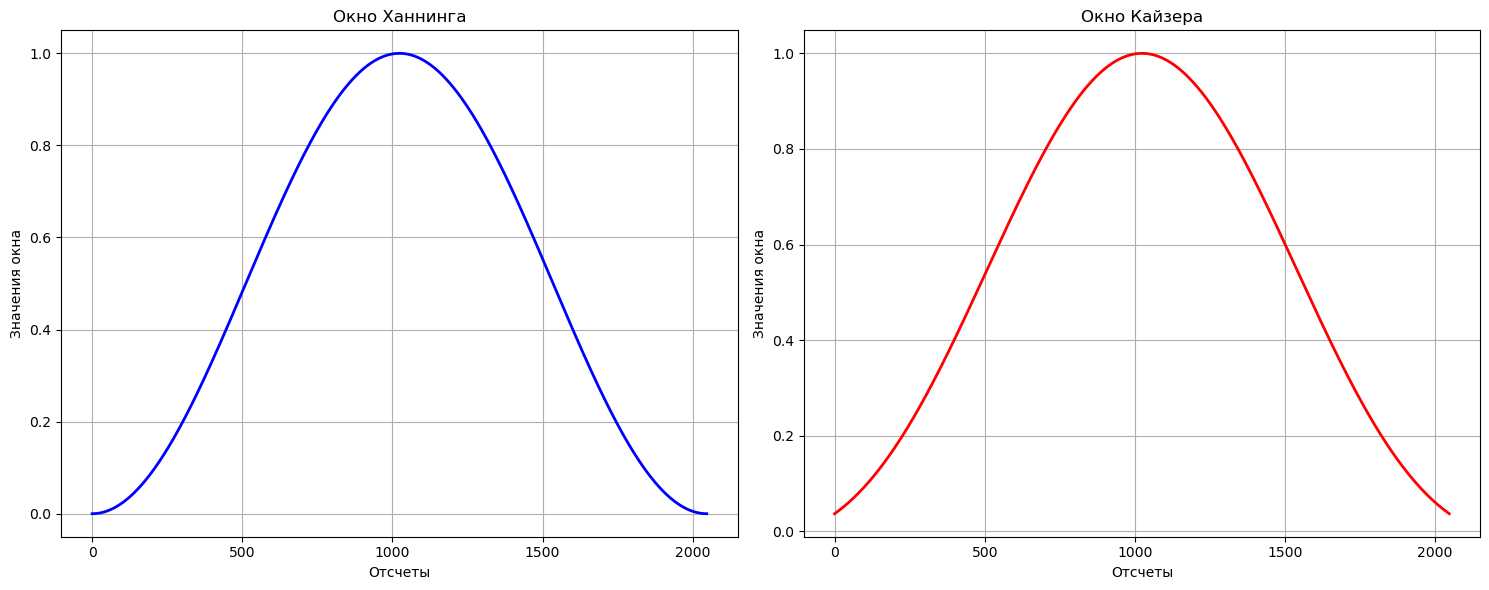

In [17]:
hann_window = hanning_window(FFT_size)
k_window = kaiser_window(FFT_size, beta=5)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(hann_window, color='b', linewidth=2)
plt.title("Окно Ханнинга")
plt.xlabel('Отсчеты')
plt.ylabel('Значения окна')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_window, color='r', linewidth=2)
plt.title("Окно Кайзера")
plt.xlabel('Отсчеты')
plt.ylabel('Значения окна')
plt.grid(True)

plt.tight_layout()
plt.show()

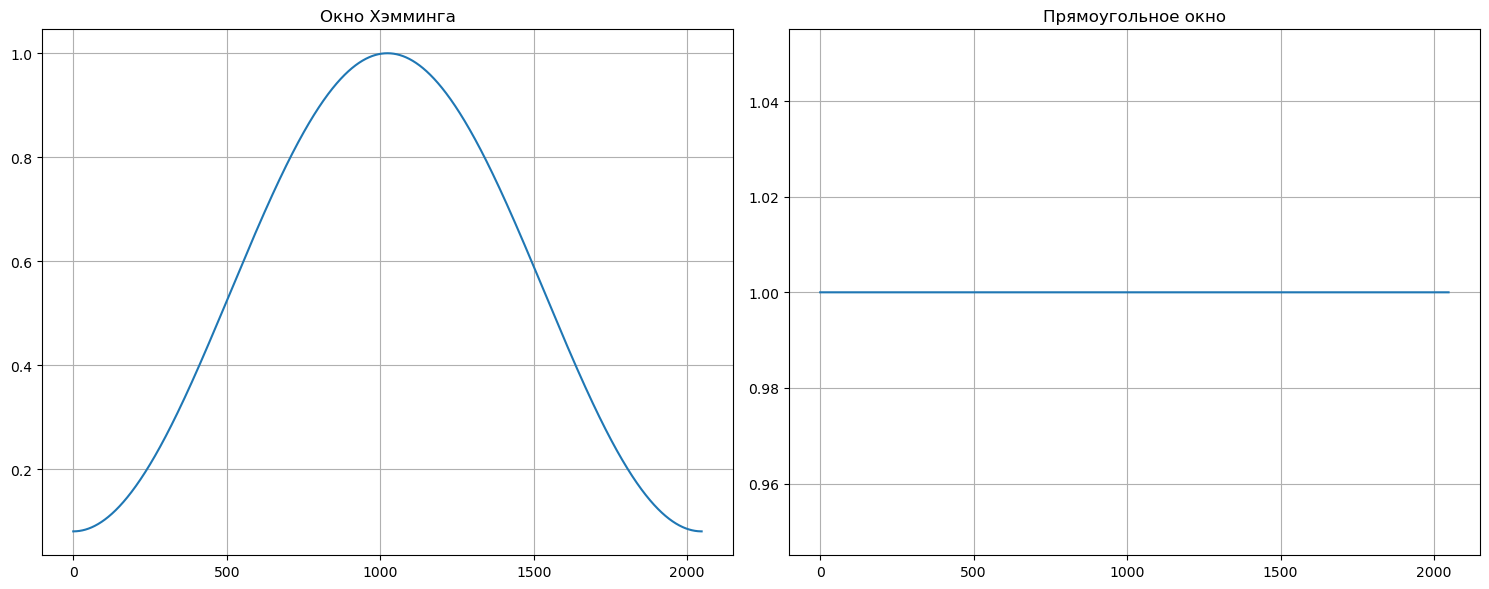

In [18]:
h_window = hamming_window(FFT_size)
rect_window = rectangular_window(FFT_size)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(h_window)
plt.title("Окно Хэмминга")
plt.grid()

# Прямоугольное окно
plt.subplot(1, 2, 2)
plt.plot(rect_window)
plt.title("Прямоугольное окно")
plt.grid()

plt.tight_layout()
plt.show()

Окно Ханнинга - простое в использовании и широко применяемое окно. Большим плюсом является то, что у него отстствуют разрывы на краях.

Чаще всего его применяют для общих задач обработки аудиосигналов, поэтому остановимся на нем.

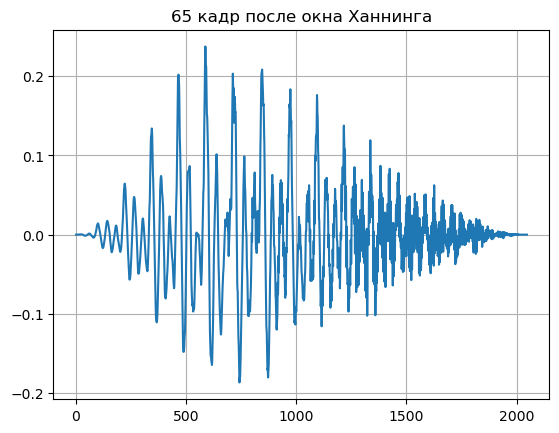

In [19]:
audio_hann = audio_data * hann_window

indexx = 65
plt.plot(audio_hann[indexx])
plt.title(f"{indexx} кадр после окна Ханнинга")
plt.grid()


Далее необходимо провести дискретное преобразование Фурье (ДПФ).

Формула следующая: 

$$x(n) =  \sum_{k=0}^{N-1}  X(k) e^{- i2\pi n k / N} = $$ 

$$\sum_{k=0}^{N-1}X(k) (\cos(\frac{2 \pi k n}{N}) + i \sin(\frac{2 \pi k n}{N})), $$
где X(k) - значение комплексного спектра на частоте 
k,
x(n) - значение сигнала на временной отсчет n, N - количество отсчетов сигнала,
k - индекс частоты в дискретном спектре (0≤k<N).

**ДПФ дает нам информацию о частотном содержании сигнала. Кроме того, это важный этап для получения мел-кепстральных коэффициентов**


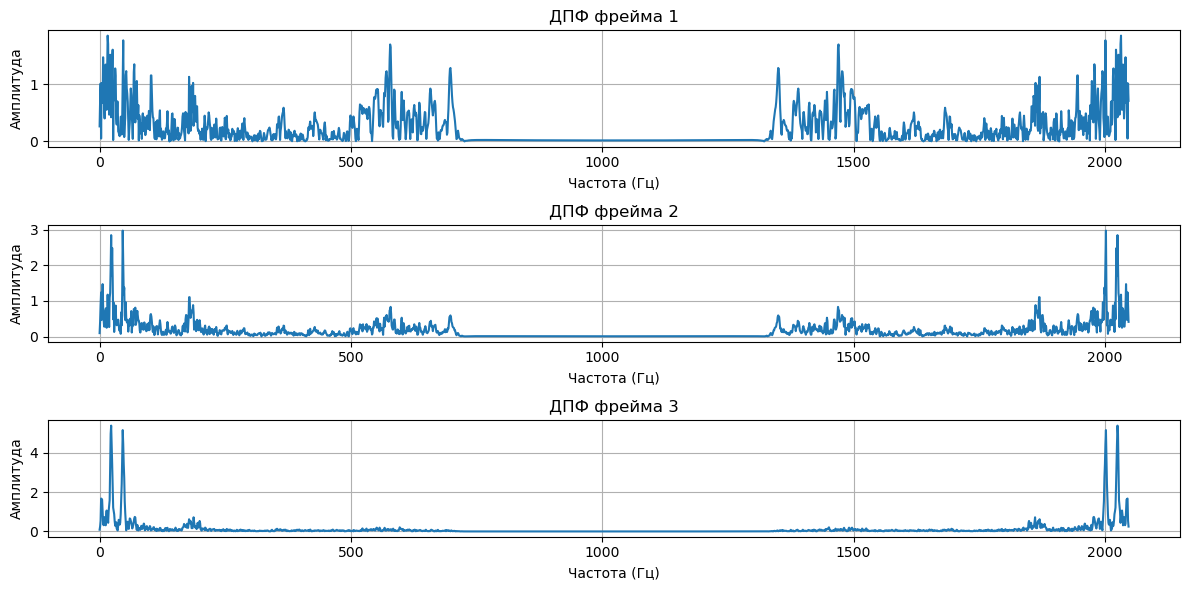

In [20]:
fft_frames = np.fft.fft(audio_hann)

plt.figure(figsize=(12, 6))

for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(np.abs(fft_frames[i]))
    plt.title(f'ДПФ фрейма {i+1}')
    plt.xlabel('Частота (Гц)')
    plt.ylabel('Амплитуда')
    plt.grid()

plt.tight_layout()
plt.show()

Не трудно заметить, что графики абсолютно симметричны. Это значит, что мы можем взять лишь половину, и она будет достаточно информативна

In [22]:
audio_hannT = audio_hann.T

# num_freq_bins - массив для сохранения результата преобразования Фурье
num_freq_bins = int(1 + FFT_size // 2)
audio_fft = np.empty((num_freq_bins, audio_hannT.shape[1]), dtype=np.complex64)

# применение преобразования Фурье к каждому фрейму
for n in range(audio_fft.shape[1]):
    audio_fft[:, n] = np.fft.fft(audio_hannT[:, n], axis=0)[:num_freq_bins]

# вернем в исходное положение
audio_fft = audio_fft.T

Важными признаками при работе с аудиофайлами являются мел-частотных кепстальных коэффициенты (MFCC). Использование MFCC позволяет сократить представление одного временного окна до 13 коэффициентов, каждый из которых вносит значительный вклад в конечный спектр.

In [23]:
def hz_to_mel(freq):
    return 2595 * np.log10(1 + freq / 700)


def mel_to_hz(mels):
    return 700 * (10**(mels / 2595) - 1)

In [24]:
def get_filter_points(fmin, fmax, mel_filter_num, FFT_size, sample_rate=44100):
    fmin_mel = hz_to_mel(fmin)
    fmax_mel = hz_to_mel(fmax)

    print(f"Минимальный MEL: {fmin_mel}")
    print(f"Максимальный MEL: {fmax_mel}")

    mels = np.linspace(fmin_mel, fmax_mel, num=mel_filter_num + 2)
    freqs = mel_to_hz(mels)

    return np.floor((FFT_size + 1) / sample_rate * freqs).astype(int), freqs

In [27]:
freq_min = 0
freq_high = sr / 2
mel_filter_num = 10

print(f"Минимальная частота: {freq_min}")
print(f"Максимальная частота: {freq_high}")

filter_points, mel_freqs = get_filter_points(
    freq_min, freq_high, mel_filter_num, FFT_size, sample_rate=sr
)
filter_points.shape, mel_freqs.shape

Минимальная частота: 0
Максимальная частота: 11025.0
Минимальный MEL: 0.0
Максимальный MEL: 3176.318435512582


((12,), (12,))

Мел-фильтры представляют собой треугольные функции, равномерно распределённые на мел-шкале. С их помощью и происходит переход к мелам

In [28]:
def get_filters(filter_points, FFT_size):
    filters = np.zeros(
        (len(filter_points) - 2, int(FFT_size / 2 + 1))
    )  # половина fft достаточна из-за отсутствия информации в отрицательной части спектра

    for n in range(len(filter_points) - 2):
        filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(
            0, 1, filter_points[n + 1] - filter_points[n]
        )  # возрастающая часть
        filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(
            1, 0, filter_points[n + 2] - filter_points[n + 1]
        )  # убывающая часть
    return filters

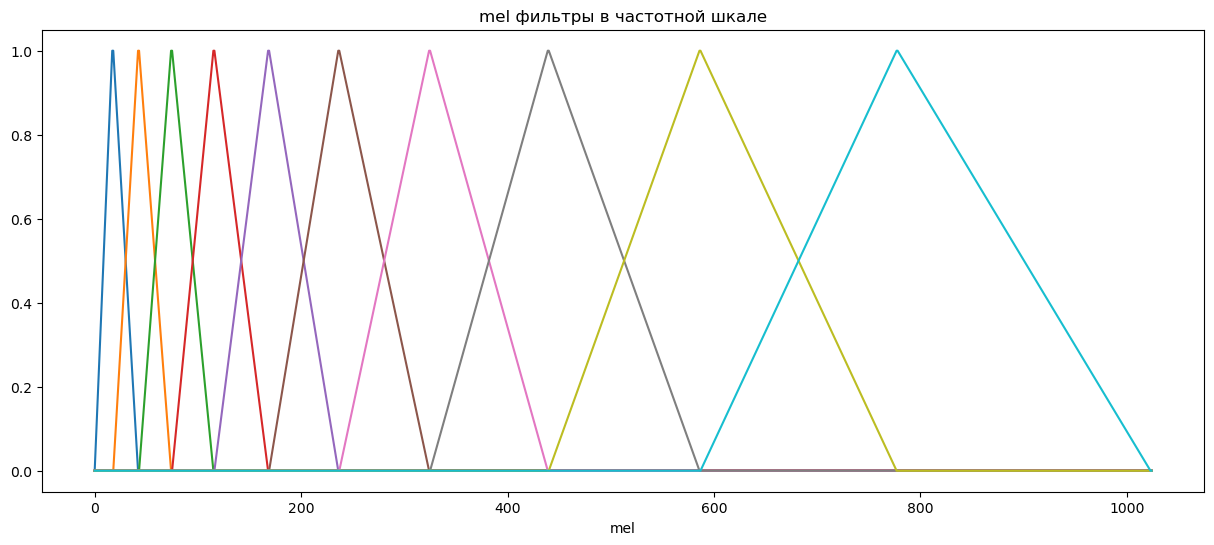

In [29]:
filters = get_filters(filter_points, FFT_size)

plt.figure(figsize=(15, 6))

for n in range(filters.shape[0]):
    plt.title("mel фильтры в частотной шкале")
    plt.plot(filters[n])
    plt.xlabel("mel")


Нормализация фильтров может быть полезной, так как при увеличении частоты количество шума также увеличивается. Это происходит потому, что фильтр на более высоких частотах становится более растянутым и охватывает больший диапазон значений.

In [99]:
enorm = 2 / (mel_freqs[2 : mel_filter_num + 2] - mel_freqs[:mel_filter_num]) 
filters *= enorm[:, np.newaxis]

Следует также произвести перевод мощности сигнала в децибелы с помощью следующей формулы 
$ D_p = 10 \cdot lg \frac{P2}{P1}$

In [35]:
audio_power = np.square(np.abs(audio_fft))
audio_filtered = np.dot(filters, audio_power.T)
audio_log = 10.0 * np.log10(audio_filtered) 
audio_log.shape

(10, 409)

В конечном этапе получения мел-кепстральных коэффициентов следует применить дискретное преобразование Фурье. Для этого можно выбрать любой из четырех типов (1, 2, 3 или 4), и я выбираю здесь тип 2, который является наиболее распространенным. Формула следующая:
$y_k = 2 \sum_{n=0}^{N-1}x(n) (\cos(\frac{\pi k (2n+1)}{2N}) $

In [101]:
n_mfccs = 20

cepstral_coefficents = fft.dct(audio_log.T, n=n_mfccs, type=2).T
cepstral_coefficents = np.nan_to_num(
    cepstral_coefficents, nan=0.0, posinf=None, neginf=0
)  # убираю None и -inf значения, возникающие из-за отсутствия сигнала
cepstral_coefficents.shape

(20, 409)


Видно, что полученные мел-кепстральные коэффициенты представляют собой матрицу размером 20 (выбранный параметр) на число, зависящее от продолжительности аудиозаписи. Большинство моделей принимают данные в векторном формате. Одно из возможных решений - это преобразовать матрицу в вектор, но это приводит к большому числу признаков. Также для выравнивания всех данных по длине по второму измерению необходимо выполнить обрезку или дополнение нулями, что также создает либо много нулевых признаков, либо усекает важные данные.

Для решения этой проблемы я применяю другой подход. Вместо этого я использую показатели, такие как минимум, максимум и среднее по первому измерению в качестве признаков для моей модели. Это позволяет получить 60 признаков (3 значения для каждого из 20 каналов), которые, как будет показано далее, хорошо работают для классификации выборки.

# Загрузка и описание датасета

Для данной работы я буду использовать VoxCeleb - большой набор данных, предназначенный для исследований в области идентификации личности по голосу. Голоса представлены в формате коротких фрагментов, что делает их подходящими для анализа и использования в задачах распознавания и идентификации голоса. Поскольку датасет очень большой, для экономии возьмем тестовую часть базы VoxCeleb (vox1_test_wav), в ней содержатся аудиозаписи $40$ различных дикторов. Аудио фрагменты представлены в формате .wav.

Ссылка на сам датасет: https://www.kaggle.com/datasets/bachng/voxceleb?rvi=1

In [38]:
root = 'vox1_test_wav\\wav'

n = 10

data = {}

for id in os.listdir(root):
    data[id] = []
    for file in sorted(glob.glob(f"{root}/{id}/*/*"))[:n]:
        data[id].append(file)
        
#отберем только те, в которых записей нужное кол-во, чтобы не включать корневые папки        
data = {k: v for k, v in data.items() if len(v) == n}
#преобразуем к датафрейму
data = pd.DataFrame(data).melt().rename(columns={'variable': 'id', 'value': 'file'})
data.head()

,id,file
0,id10270,vox1_test_wav\wav/id10270\5r0dWxy17C8\00001.wav
1,id10270,vox1_test_wav\wav/id10270\5r0dWxy17C8\00002.wav
2,id10270,vox1_test_wav\wav/id10270\5r0dWxy17C8\00003.wav
3,id10270,vox1_test_wav\wav/id10270\5r0dWxy17C8\00004.wav
4,id10270,vox1_test_wav\wav/id10270\5r0dWxy17C8\00005.wav


In [39]:
#Поставим в соответствие каждому id пол говорящего - нашу целевую переменную

genders = {'id10270': 'F', 'id10271': 'M', 'id10272': 'M', 'id10273': 'M', 'id10274': 'M',
           'id10275': 'M', 'id10276': 'M', 'id10277': 'M', 'id10278': 'M', 'id10279': 'M',
           'id10280': 'F', 'id10281': 'F', 'id10282': 'F', 'id10283': 'M', 'id10284': 'M',
           'id10285': 'F', 'id10286': 'F', 'id10287': 'F', 'id10288': 'F', 'id10289': 'F',
           'id10290': 'M', 'id10291': 'F', 'id10292': 'M', 'id10293': 'M', 'id10294': 'M',
           'id10295': 'M', 'id10296': 'M', 'id10297': 'M', 'id10298': 'M', 'id10299': 'F',
           'id10300': 'M', 'id10301': 'M', 'id10302': 'M', 'id10303': 'F', 'id10304': 'M',
           'id10305': 'M', 'id10306': 'F', 'id10307': 'F', 'id10308': 'F', 'id10309': 'M'}

data['gender'] = data['id'].map(genders)

print(data.head())

        id                                             file gender
0  id10270  vox1_test_wav\wav/id10270\5r0dWxy17C8\00001.wav      F
1  id10270  vox1_test_wav\wav/id10270\5r0dWxy17C8\00002.wav      F
2  id10270  vox1_test_wav\wav/id10270\5r0dWxy17C8\00003.wav      F
3  id10270  vox1_test_wav\wav/id10270\5r0dWxy17C8\00004.wav      F
4  id10270  vox1_test_wav\wav/id10270\5r0dWxy17C8\00005.wav      F


In [40]:
print(data.info())

print(data.head())

print(data['gender'].value_counts()) # дисбаланс в данных незначительный

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      400 non-null    object
 1   file    400 non-null    object
 2   gender  400 non-null    object
dtypes: object(3)
memory usage: 9.5+ KB
None
        id                                             file gender
0  id10270  vox1_test_wav\wav/id10270\5r0dWxy17C8\00001.wav      F
1  id10270  vox1_test_wav\wav/id10270\5r0dWxy17C8\00002.wav      F
2  id10270  vox1_test_wav\wav/id10270\5r0dWxy17C8\00003.wav      F
3  id10270  vox1_test_wav\wav/id10270\5r0dWxy17C8\00004.wav      F
4  id10270  vox1_test_wav\wav/id10270\5r0dWxy17C8\00005.wav      F
gender
M    250
F    150
Name: count, dtype: int64


Извлечем все необходимые признаки для нашего датасета

In [41]:
data['gender'] = data['gender'].replace({'F': 0, 'M': 1})

In [42]:
data

,id,file,gender
0,id10270,vox1_test_wav\wav/id10270\5r0dWxy17C8\00001.wav,0
1,id10270,vox1_test_wav\wav/id10270\5r0dWxy17C8\00002.wav,0
2,id10270,vox1_test_wav\wav/id10270\5r0dWxy17C8\00003.wav,0
3,id10270,vox1_test_wav\wav/id10270\5r0dWxy17C8\00004.wav,0
4,id10270,vox1_test_wav\wav/id10270\5r0dWxy17C8\00005.wav,0
...,...,...,...
395,id10309,vox1_test_wav\wav/id10309\0b1inHMAr6o\00006.wav,1
396,id10309,vox1_test_wav\wav/id10309\0b1inHMAr6o\00007.wav,1
397,id10309,vox1_test_wav\wav/id10309\0b1inHMAr6o\00008.wav,1
398,id10309,vox1_test_wav\wav/id10309\0b1inHMAr6o\00009.wav,1


В качестве признаков выступают среднее, минимальное и максимальное значения: 
*   MFCC - коэффициенты, которые описывают форму спектра мощности сигнала на мел-шкале частот.

*    Chroma - спектральный признак, который отражает распределение энергии сигнала по октавам и нотам в музыкальной шкале. 

*    Tonnetz - признаковое представление аудиосигнала, которое отражает гармоническую структуру музыки

*    Zero Crossing Rate (ZCR) - число пересечений нуля в пределах сегмента этого сигнала

In [43]:
def get_mfcc(wav_file_path):
    y, sr = librosa.load(wav_file_path, offset=0, duration=30)
    mfcc = np.array(librosa.feature.mfcc(y=y, sr=sr))
    return mfcc

In [45]:
def get_chroma_vector(wav_file_path):
    y, sr = librosa.load(wav_file_path)
    chroma = np.array(librosa.feature.chroma_stft(y=y, sr=sr))
    return chroma

In [46]:
def get_tonnetz(wav_file_path):
    y, sr = librosa.load(wav_file_path)
    tonnetz = np.array(librosa.feature.tonnetz(y=y, sr=sr))
    return tonnetz

In [58]:
def get_zero_crossing_rate(wav_file_path):
    y, sr = librosa.load(wav_file_path, sr=None)
    zcr = librosa.feature.zero_crossing_rate(y)
    return zcr

In [83]:
def extract_features(file_path):
    mfcc = get_mfcc(file_path)
    mfcc_mean = mfcc.mean(axis=1)
    mfcc_min = mfcc.min(axis=1)
    mfcc_max = mfcc.max(axis=1)
    mfcc_feature = np.concatenate( (mfcc_mean, mfcc_min, mfcc_max) )

    chroma = get_chroma_vector(file_path)
    chroma_mean = chroma.mean(axis=1)
    chroma_min = chroma.min(axis=1)
    chroma_max = chroma.max(axis=1)
    chroma_feature = np.concatenate( (chroma_mean, chroma_min, chroma_max) )

    tntz = get_tonnetz(file_path)
    tntz_mean = tntz.mean(axis=1)
    tntz_min = tntz.min(axis=1)
    tntz_max = tntz.max(axis=1)
    tntz_feature = np.concatenate( (tntz_mean, tntz_min, tntz_max) ) 
    
    zcr = get_zero_crossing_rate(file_path)
    zcr_mean = zcr.mean(axis=1)
    zcr_min = zcr.min(axis=1)
    zcr_max = zcr.max(axis=1)
    zcr_feature = np.concatenate( (zcr_mean, zcr_min, zcr_max) )

    feature = np.concatenate((chroma_feature, mfcc_feature, tntz_feature, zcr_feature) )
    return feature

In [84]:
# Применяем функцию к каждой строке DataFrame и создаем новый столбец с признаками
data['features'] = data['file'].apply(extract_features)

In [85]:
data

,id,file,gender,features
0,id10270,vox1_test_wav\wav/id10270\5r0dWxy17C8\00001.wav,0,"[0.36384832859039307, 0.37087416648864746, 0.4..."
1,id10270,vox1_test_wav\wav/id10270\5r0dWxy17C8\00002.wav,0,"[0.2636171877384186, 0.3269761800765991, 0.333..."
2,id10270,vox1_test_wav\wav/id10270\5r0dWxy17C8\00003.wav,0,"[0.37711310386657715, 0.47063079476356506, 0.5..."
3,id10270,vox1_test_wav\wav/id10270\5r0dWxy17C8\00004.wav,0,"[0.34581753611564636, 0.3864773213863373, 0.43..."
4,id10270,vox1_test_wav\wav/id10270\5r0dWxy17C8\00005.wav,0,"[0.384499728679657, 0.36288541555404663, 0.383..."
...,...,...,...,...
395,id10309,vox1_test_wav\wav/id10309\0b1inHMAr6o\00006.wav,1,"[0.41982796788215637, 0.4207025468349457, 0.41..."
396,id10309,vox1_test_wav\wav/id10309\0b1inHMAr6o\00007.wav,1,"[0.43285346031188965, 0.456917405128479, 0.428..."
397,id10309,vox1_test_wav\wav/id10309\0b1inHMAr6o\00008.wav,1,"[0.2652292549610138, 0.30540788173675537, 0.33..."
398,id10309,vox1_test_wav\wav/id10309\0b1inHMAr6o\00009.wav,1,"[0.33290815353393555, 0.3241962790489197, 0.37..."


Разделение данных на обучающую и тестовую выборки

In [87]:
X = data.features
y = data.gender

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = np.vstack(X_train)  
X_test = np.vstack(X_test)    
y_train = y_train.values      
y_test = y_test.values        

# Построение моделей классификации
## 1. Логистическая регрессия

In [88]:
start_time = time.time()
logistic_regression = LogisticRegression(max_iter=1000, random_state=42)
logistic_regression.fit(X_train, y_train)
end_time = time.time()

# Оценка модели
logistic_regression_pred = logistic_regression.predict(X_test)
accuracy = accuracy_score(y_test, logistic_regression_pred)
precision = precision_score(y_test, logistic_regression_pred, pos_label=0)
recall = recall_score(y_test, logistic_regression_pred, pos_label=0)
f1 = f1_score(y_test, logistic_regression_pred, pos_label=0)

# Вывод результатов
print("Модель: Логистическая регрессия")
print("Время обучения: {:.2f} сек".format(end_time - start_time))
print("Accuracy:", accuracy)
print("Precision (F):", precision)
print("Recall (F):", recall)
print("F1-score (F):", f1)
print(classification_report(y_test, logistic_regression_pred))

Модель: Логистическая регрессия
Время обучения: 0.23 сек
Accuracy: 0.9375
Precision (F): 0.8709677419354839
Recall (F): 0.9642857142857143
F1-score (F): 0.9152542372881356
              precision    recall  f1-score   support

           0       0.87      0.96      0.92        28
           1       0.98      0.92      0.95        52

    accuracy                           0.94        80
   macro avg       0.93      0.94      0.93        80
weighted avg       0.94      0.94      0.94        80



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


В целом, модель логистической регрессии показывает хорошее качество предсказаний с высокими значениями точности, полноты и F1-меры для обоих классов. Точность модели также подтверждается хорошим значением accuracy.

## 2. Метод опорных векторов (SVM)

In [89]:
start_time = time.time()
svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train, y_train)
end_time = time.time()

# Оценка модели
svm_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, svm_pred)
precision = precision_score(y_test, svm_pred, pos_label=0)
recall = recall_score(y_test, svm_pred, pos_label=0)
f1 = f1_score(y_test, svm_pred, pos_label=0)

print("\nМодель: Метод опорных векторов (SVM)")
print("Время обучения: {:.2f} сек".format(end_time - start_time))
print("Accuracy:", accuracy)
print("Precision (F):", precision)
print("Recall (F):", recall)
print("F1-score (F):", f1)
print(classification_report(y_test, svm_pred))


Модель: Метод опорных векторов (SVM)
Время обучения: 0.01 сек
Accuracy: 0.95
Precision (F): 0.875
Recall (F): 1.0
F1-score (F): 0.9333333333333333
              precision    recall  f1-score   support

           0       0.88      1.00      0.93        28
           1       1.00      0.92      0.96        52

    accuracy                           0.95        80
   macro avg       0.94      0.96      0.95        80
weighted avg       0.96      0.95      0.95        80



## 3. Случайный лес (Random Forest)

In [90]:
start_time = time.time()
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)
end_time = time.time()

# Оценка модели
random_forest_pred = random_forest.predict(X_test)
accuracy = accuracy_score(y_test, random_forest_pred)
precision = precision_score(y_test, random_forest_pred, pos_label=0)
recall = recall_score(y_test, random_forest_pred, pos_label=0)
f1 = f1_score(y_test, random_forest_pred, pos_label=0)

# Вывод результатов
print("\nМодель: Случайный лес (Random Forest)")
print("Время обучения: {:.2f} сек".format(end_time - start_time))
print("Accuracy:", accuracy)
print("Precision (F):", precision)
print("Recall (F):", recall)
print("F1-score (F):", f1)
print(classification_report(y_test, random_forest_pred))


Модель: Случайный лес (Random Forest)
Время обучения: 0.62 сек
Accuracy: 0.95
Precision (F): 1.0
Recall (F): 0.8571428571428571
F1-score (F): 0.923076923076923
              precision    recall  f1-score   support

           0       1.00      0.86      0.92        28
           1       0.93      1.00      0.96        52

    accuracy                           0.95        80
   macro avg       0.96      0.93      0.94        80
weighted avg       0.95      0.95      0.95        80



## 4. Градиентный бустинг (Gradient Boosting)

In [91]:
start_time = time.time()
gradient_boosting = GradientBoostingClassifier(n_estimators=100, random_state=42)
gradient_boosting.fit(X_train, y_train)
end_time = time.time()

# Оценка модели
gradient_boosting_pred = gradient_boosting.predict(X_test)
accuracy = accuracy_score(y_test, gradient_boosting_pred)
precision = precision_score(y_test, gradient_boosting_pred, pos_label=0)
recall = recall_score(y_test, gradient_boosting_pred, pos_label=0)
f1 = f1_score(y_test, gradient_boosting_pred, pos_label=0)

# Вывод результатов
print("\nМодель: Градиентный бустинг (Gradient Boosting)")
print("Время обучения: {:.2f} сек".format(end_time - start_time))
print("Accuracy:", accuracy)
print("Precision (F):", precision)
print("Recall (F):", recall)
print("F1-score (F):", f1)
print(classification_report(y_test, gradient_boosting_pred))


Модель: Градиентный бустинг (Gradient Boosting)
Время обучения: 4.61 сек
Accuracy: 0.975
Precision (F): 1.0
Recall (F): 0.9285714285714286
F1-score (F): 0.962962962962963
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        28
           1       0.96      1.00      0.98        52

    accuracy                           0.97        80
   macro avg       0.98      0.96      0.97        80
weighted avg       0.98      0.97      0.97        80



## 5. k-ближайших соседей (kNN)

In [92]:
start_time = time.time()
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
end_time = time.time()

knn_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, knn_pred)
precision = precision_score(y_test, knn_pred, pos_label=0)
recall = recall_score(y_test, knn_pred, pos_label=0)
f1 = f1_score(y_test, knn_pred, pos_label=0)


print("\nМодель: k-ближайших соседей (kNN)")
print("Время обучения: {:.2f} сек".format(end_time - start_time))
print("Accuracy:", accuracy)
print("Precision (F):", precision)
print("Recall (F):", recall)
print("F1-score (F):", f1)
print(classification_report(y_test, knn_pred))


Модель: k-ближайших соседей (kNN)
Время обучения: 0.00 сек
Accuracy: 0.9125
Precision (F): 0.8181818181818182
Recall (F): 0.9642857142857143
F1-score (F): 0.8852459016393442
              precision    recall  f1-score   support

           0       0.82      0.96      0.89        28
           1       0.98      0.88      0.93        52

    accuracy                           0.91        80
   macro avg       0.90      0.92      0.91        80
weighted avg       0.92      0.91      0.91        80



## 6. Наивный байесовский классификатор (Naive Bayes)

In [93]:
start_time = time.time()
naive_bayes = GaussianNB()
naive_bayes.fit(X_train, y_train)
end_time = time.time()

naive_bayes_pred = naive_bayes.predict(X_test)
accuracy = accuracy_score(y_test, naive_bayes_pred)
precision = precision_score(y_test, naive_bayes_pred, pos_label=0)
recall = recall_score(y_test, naive_bayes_pred, pos_label=0)
f1 = f1_score(y_test, naive_bayes_pred, pos_label=0)


print("\nМодель: Наивный байесовский классификатор (Naive Bayes)")
print("Время обучения: {:.2f} сек".format(end_time - start_time))
print("Accuracy:", accuracy)
print("Precision (F):", precision)
print("Recall (F):", recall)
print("F1-score (F):", f1)
print(classification_report(y_test, naive_bayes_pred))


Модель: Наивный байесовский классификатор (Naive Bayes)
Время обучения: 0.00 сек
Accuracy: 0.9
Precision (F): 0.9545454545454546
Recall (F): 0.75
F1-score (F): 0.84
              precision    recall  f1-score   support

           0       0.95      0.75      0.84        28
           1       0.88      0.98      0.93        52

    accuracy                           0.90        80
   macro avg       0.92      0.87      0.88        80
weighted avg       0.91      0.90      0.90        80



## 7. Каскады решающих деревьев (CatBoost)

In [94]:
start_time = time.time()
catboost = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, random_seed=42)
catboost.fit(X_train, y_train, verbose=False)
end_time = time.time()

# Оценка модели
catboost_pred = catboost.predict(X_test)
accuracy = accuracy_score(y_test, catboost_pred)
precision = precision_score(y_test, catboost_pred, pos_label=0)
recall = recall_score(y_test, catboost_pred, pos_label=0)
f1 = f1_score(y_test, catboost_pred, pos_label=0)

# Вывод результатов
print("\nМодель: Каскады решающих деревьев (CatBoost)")
print("Время обучения: {:.2f} сек".format(end_time - start_time))
print("Accuracy:", accuracy)
print("Precision (F):", precision)
print("Recall (F):", recall)
print("F1-score (F):", f1)
print(classification_report(y_test, catboost_pred))


Модель: Каскады решающих деревьев (CatBoost)
Время обучения: 1.91 сек
Accuracy: 0.9875
Precision (F): 1.0
Recall (F): 0.9642857142857143
F1-score (F): 0.9818181818181818
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        28
           1       0.98      1.00      0.99        52

    accuracy                           0.99        80
   macro avg       0.99      0.98      0.99        80
weighted avg       0.99      0.99      0.99        80



**Для поиска наилучших параметров для модели k ближайших соседей воспользуемся поиском по сетке**

In [95]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}


grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')

grid_search_knn.fit(X_train, y_train)


print("Лучшие параметры для метода ближайших соседей:", grid_search_knn.best_params_)


best_knn_model = grid_search_knn.best_estimator_
knn_pred = best_knn_model.predict(X_test)
accuracy = accuracy_score(y_test, knn_pred)
precision = precision_score(y_test, knn_pred, pos_label=0)
recall = recall_score(y_test, knn_pred, pos_label=0)
f1 = f1_score(y_test, knn_pred, pos_label=0)

print("\nМетрики производительности для метода ближайших соседей с лучшими параметрами:")
print("Accuracy:", accuracy)
print("Precision (F):", precision)
print("Recall (F):", recall)
print("F1-score (F):", f1)

Лучшие параметры для метода ближайших соседей: {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'uniform'}

Метрики производительности для метода ближайших соседей с лучшими параметрами:
Accuracy: 0.9125
Precision (F): 0.8181818181818182
Recall (F): 0.9642857142857143
F1-score (F): 0.8852459016393442


In [96]:
start_time = time.time()
knn_best = KNeighborsClassifier(algorithm='auto', n_neighbors=5, weights='distance')
knn_best.fit(X_train, y_train)
end_time = time.time()

knn_pred = knn_best.predict(X_test)
accuracy = accuracy_score(y_test, knn_pred)
precision = precision_score(y_test, knn_pred, pos_label=0)
recall = recall_score(y_test, knn_pred, pos_label=0)
f1 = f1_score(y_test, knn_pred, pos_label=0)


print("\nМодель: k-ближайших соседей (kNN)")
print("Время обучения: {:.2f} сек".format(end_time - start_time))
print("Accuracy:", accuracy)
print("Precision (F):", precision)
print("Recall (F):", recall)
print("F1-score (F):", f1)
print(classification_report(y_test, knn_pred))


Модель: k-ближайших соседей (kNN)
Время обучения: 0.00 сек
Accuracy: 0.925
Precision (F): 0.84375
Recall (F): 0.9642857142857143
F1-score (F): 0.8999999999999999
              precision    recall  f1-score   support

           0       0.84      0.96      0.90        28
           1       0.98      0.90      0.94        52

    accuracy                           0.93        80
   macro avg       0.91      0.93      0.92        80
weighted avg       0.93      0.93      0.93        80



Можно видеть незначительное улучшение модели, но в целом ситуация изменяется незначительно.

# Заключение

В данной работе был провед анализ аудиоданных, извлечены основные признаки. Для идентификации личности по голосу можно использовать различные признаки. Если речь идет просто про определения пола, то с этим обученной модели не представляет труда справиться. Например, довольно характерно, что у мужчин основная частота колеблется от 85 Гц до 180 Гц, в то время как у женщин она составляет от 168 Гц до 255 Гц. В то же время, если бы стояла задача идентификации уникального голоса, показатели не были бы так высоки.

В данной работе были рассмотрены $7$ различных моделей классификации. Все модели показали достаточно хорошие метрики в классификации пола по голосу. 